# Power Quality Classification using CNN

This notebook focusses on developing a Convolutional Neural Network which classifies a particular power signal into its respective power quality condition. The dataset used here contains signals which belong to one of the 6 classes(power quality condition). The sampling rate of this data is 256. This means that each signal is characterized by 256 data points. Here the signals provided are in time domain.

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fft import fft,fftfreq
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
#loading the dataset using pandas
x_train = pd.read_csv("../Dataset2/Train/Voltage_L1_train.csv")
y_train = pd.read_csv("../Dataset2/Train/output_train.csv")
x_test = pd.read_csv("../Dataset2/Test/Voltage_L1_test.csv")
y_test = pd.read_csv("../Dataset2/Test/output_test.csv")

In [3]:
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (5999, 256)
y_train (5999, 1)
x_test (3599, 256)
y_test (3599, 1)


## Data Preprocessing

This segment of notebook contains all the preprocessing steps which are performed on the data.

In [4]:
#dropna() function is used to remove all those rows which contains NA values
x_train.dropna(axis=0,inplace=True)
y_train.dropna(axis=0,inplace=True)
x_test.dropna(axis=0,inplace=True)
y_test.dropna(axis=0,inplace=True)

In [5]:
#shape of the data frames after dropping the rows containing NA values
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (5999, 256)
y_train (5999, 1)
x_test (3599, 256)
y_test (3599, 1)


In [6]:
#here we are constructing the array which will finally contain the column names
header =[]
for i in range(1,x_train.shape[1]+1):
    header.append("Col"+str(i))

In [7]:
#assigning the column name array to the respectinve dataframes
x_train.columns = header
x_test.columns = header

In [8]:
#assinging the column name for the y_train and y_test
header = ["output"]
y_train.columns = header
y_test.columns = header

In [9]:
x_train.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col247,Col248,Col249,Col250,Col251,Col252,Col253,Col254,Col255,Col256
0,573.652486,1003.343736,1588.404525,2317.576741,2804.364311,3225.322510,3662.821690,4174.627969,4656.244143,4939.070130,...,-4650.282434,-4228.581226,-3865.609932,-3395.654756,-2933.680470,-2322.450904,-1841.562453,-1282.042025,-601.968217,-156.848367
1,4757.365183,5264.598912,5428.642486,5650.413073,5939.710012,5911.948067,6147.642171,6076.921501,5958.797444,6053.817701,...,-280.360872,323.325836,861.103019,1415.929276,2007.692919,2561.130303,2960.282598,3619.932691,4008.288701,4422.229911
2,4242.144824,4644.679402,5013.356532,5229.417051,5534.898007,5797.190678,5930.658682,5960.014599,6055.336310,6103.707793,...,-1256.270585,-616.527428,-67.068193,549.016676,1099.652199,1697.572166,2239.961604,2776.876479,3248.638662,3807.665149
3,2077.819247,2561.679246,3085.653813,3545.905160,4023.421592,4496.705157,4809.079868,5186.298840,5453.627533,5737.354699,...,-3557.345152,-3017.951179,-2596.647329,-1996.266675,-1467.203661,-885.101101,-329.685256,304.222722,935.528504,1460.127297
4,3599.645319,4099.944762,4499.282469,4897.875855,5120.077118,5402.227743,5694.801362,5928.683099,5981.616502,6052.006904,...,-2020.240712,-1388.704968,-849.731284,-232.632694,341.406093,854.579135,1528.023058,2002.557438,2576.468343,3036.303600


In [10]:
x_test.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col247,Col248,Col249,Col250,Col251,Col252,Col253,Col254,Col255,Col256
0,4216.164293,4550.919227,4885.253969,5265.577080,5634.058181,5690.878844,5984.805444,6083.124480,6024.018340,6144.339029,...,-1279.720481,-672.204610,-35.247405,565.001817,1139.580709,1623.258946,2159.189259,2729.066018,3292.437301,3770.985050
1,795.638794,1340.736614,1928.805243,2465.916079,3009.942949,3475.153730,3938.568022,4372.781654,4765.603003,5090.817748,...,-4525.083123,-4077.498908,-3630.262875,-3176.648183,-2652.563485,-2135.982927,-1549.968773,-970.063115,-413.973048,202.507328
2,1220.943267,1770.550513,2318.816674,2850.186275,3357.786987,3848.017230,4274.339651,4669.175893,5027.840955,5329.856655,...,-4214.790563,-3762.024055,-3303.182589,-2802.950592,-2246.516780,-1712.153266,-1120.729328,-553.276475,43.863168,614.870963
3,1013.772210,1621.783618,2178.146635,2733.460484,3178.151416,3692.797702,4177.895304,4539.640464,4948.873847,5271.862849,...,-4371.401183,-3937.075334,-3502.317297,-2922.179500,-2467.320667,-1904.033355,-1362.385474,-704.032900,-188.518269,466.064827
4,4490.355896,4862.601717,5235.681699,5401.432840,5741.255908,5840.507807,6030.352157,6037.480783,6109.355580,6000.190091,...,-848.410798,-279.507713,269.777288,853.806015,1410.187144,1977.999116,2621.735468,3069.781180,3624.993700,4116.325633


In [11]:
y_train.head()

,output
0,1
1,1
2,1
3,1
4,1


In [12]:
y_test.head()

,output
0,1
1,1
2,1
3,1
4,1


In [13]:
#further splitting the train dataset to train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [14]:
print('x_train',x_train.shape)
print('y_train',y_train.shape)
print('x_val',x_val.shape)
print('y_val',y_val.shape)
print('x_test',x_test.shape)
print('y_test',y_test.shape)

x_train (4799, 256)
y_train (4799, 1)
x_val (1200, 256)
y_val (1200, 1)
x_test (3599, 256)
y_test (3599, 1)


In [15]:
# get_dummies function is used here to perform one hot encoding of the y_* numpy arrays
y_train_hot = pd.get_dummies(y_train['output'])
y_test_hot = pd.get_dummies(y_test['output'])
y_val_hot = pd.get_dummies(y_val['output'])

In [16]:
y_train_hot.head()

,1,2,3,4,5,6
5627,0,0,0,0,0,1
1755,0,1,0,0,0,0
2344,0,0,1,0,0,0
4283,0,0,0,0,1,0
3034,0,0,0,1,0,0


In [17]:
y_train_arr = y_train_hot.to_numpy()
y_test_arr = y_test_hot.to_numpy()
y_val_arr = y_val_hot.to_numpy()
print("y_train:",y_train_arr.shape)
print("y_test:",y_test_arr.shape)
print("y_val:",y_val_arr.shape)
no_of_classes = y_train_arr.shape[1]

y_train: (4799, 6)
y_test: (3599, 6)
y_val: (1200, 6)


### Data transformation

The data transformation steps employed here are as follows:<br>

1) Fourier Transform<br>
2) Normalization

In [18]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()
for i in range(0,x_train.shape[0]):
    x_train[i][:] = fft(x_train[i][:])
    
for i in range(0,x_test.shape[0]):
    x_test[i][:] = fft(x_test[i][:])

for i in range(0,x_val.shape[0]):
    x_val[i][:] = fft(x_val[i][:])

<ipython-input-18-8af77d55593a>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  x_train[i][:] = fft(x_train[i][:])
<ipython-input-18-8af77d55593a>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  x_test[i][:] = fft(x_test[i][:])
<ipython-input-18-8af77d55593a>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  x_val[i][:] = fft(x_val[i][:])


In [19]:
transform = StandardScaler()
x_train_tr = transform.fit_transform(x_train)
x_test_tr = transform.fit_transform(x_test)
x_val_tr = transform.fit_transform(x_val)

In [20]:
print("Training",x_train_tr.shape)
print(y_train_arr.shape)
print("Validation",x_val_tr.shape)
print(y_val_arr.shape)
print("Test",x_test_tr.shape)
print(y_test_arr.shape)
sampling_rate = x_train_tr.shape[1]

Training (4799, 256)
(4799, 6)
Validation (1200, 256)
(1200, 6)
Test (3599, 256)
(3599, 6)


## Model creation and training

In [21]:
#Reshaping the Data so that it could be used in 1D CNN
x_train_re = x_train.reshape(x_train_tr.shape[0],x_train_tr.shape[1], 1)
x_test_re = x_test.reshape(x_test_tr.shape[0],x_test_tr.shape[1], 1)
x_val_re = x_val.reshape(x_val_tr.shape[0],x_val_tr.shape[1], 1)

In [22]:
x_train_re.shape

(4799, 256, 1)

In [23]:
#importing required modules for working with CNN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2

In [24]:
#initializing required parameters for the model
batch_size = 64
num_classes = 6
epochs = 20
input_shape=(x_train_tr.shape[1], 1)

In [25]:
model = Sequential()
model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
#model.add(Dense(64, activation='tanh'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 128)          512       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 128)          49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [27]:
#compiling the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
#training the model
history = model.fit(x_train_re, y_train_hot, batch_size=batch_size, epochs=epochs, validation_data=(x_val_re, y_val_hot))


Epoch 1/20
75/75 [==============================] - 7s 88ms/step - loss: 1.6769 - accuracy: 0.3242 - val_loss: 2.8356 - val_accuracy: 0.3342
Epoch 2/20
75/75 [==============================] - 6s 86ms/step - loss: 0.8535 - accuracy: 0.6614 - val_loss: 0.4045 - val_accuracy: 0.9083
Epoch 3/20
75/75 [==============================] - 6s 86ms/step - loss: 0.3955 - accuracy: 0.8336 - val_loss: 0.3691 - val_accuracy: 0.9425
Epoch 4/20
75/75 [==============================] - 7s 92ms/step - loss: 0.3082 - accuracy: 0.8663 - val_loss: 0.1935 - val_accuracy: 0.9533
Epoch 5/20
75/75 [==============================] - 7s 93ms/step - loss: 0.3155 - accuracy: 0.8731 - val_loss: 0.1688 - val_accuracy: 0.9592
Epoch 6/20
75/75 [==============================] - 8s 102ms/step - loss: 0.2298 - accuracy: 0.9091 - val_loss: 0.1684 - val_accuracy: 0.9575
Epoch 7/20
75/75 [==============================] - 7s 90ms/step - loss: 0.1707 - accuracy: 0.9348 - val_loss: 0.2345 - val_accuracy: 0.9383
Epoch 8/20
7

In [29]:
print(model.metrics_names)

['loss', 'accuracy']


## Model evaluation

In [30]:
pred_acc = model.evaluate(x_test_re,y_test_hot)
print("Test accuracy is {}".format(pred_acc))

113/113 [==============================] - 1s 9ms/step - loss: 0.1221 - accuracy: 0.9689
Test accuracy is [0.12205296009778976, 0.9688802361488342]


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [32]:
array = confusion_matrix(y_test_hot.to_numpy().argmax(axis=1), model.predict(x_test_re).argmax(axis=1))

In [33]:
array

array([[548,  12,   7,  17,   7,   8],
       [ 20, 578,   1,   1,   0,   0],
       [  7,   0, 590,   2,   0,   1],
       [ 14,   0,   0, 585,   1,   0],
       [ 12,   0,   0,   2, 586,   0],
       [  0,   0,   0,   0,   0, 600]])

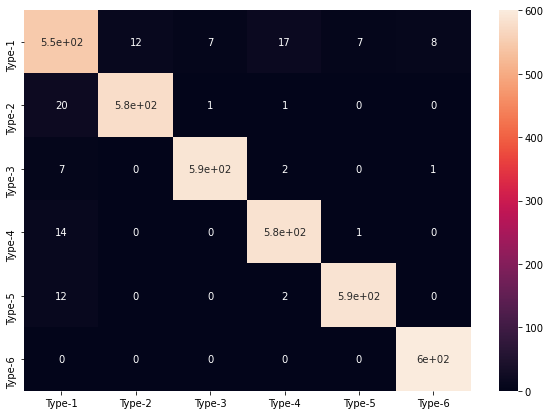

In [34]:
to_cm = pd.DataFrame(array, index = [i for i in ["Type-1","Type-2","Type-3","Type-4","Type-5","Type-6"]],
                  columns = [i for i in ["Type-1","Type-2","Type-3","Type-4","Type-5","Type-6"]])
plt.figure(figsize = (10,7))
sn.heatmap(to_cm, annot=True)

In [35]:
#model.save("CNN_model_data2.h5")